# Synopsis Only

As an experiment, we are going to showcase a variant of the project base, where only one field of the dataset will be used, to verify if significant sentiment information is contained in it.

If the performance is similar to the classifiers using the full dataset, then the field´s information density is high!

## Data Load and Exploration

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("data/dataset.csv", encoding="utf-8")

dataset.head()

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


## Data Cleaning

Let's quickly do all the needed operations

In [2]:
# Convert to binary
dataset.loc[97, "Final Status"] = "Positive"
dataset["Final Status"] = dataset["Final Status"].map({"Positive": 1, "Negative": 0})

In [3]:
# Check  and clean empty Synopsis
dataset[dataset["Synopsis"].isna()].index

Index([56], dtype='int64')

In [4]:
dataset.loc[56, "Synopsis"] = " "

## Preprocessing Text

In [5]:
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [6]:
#replace contractions
def decontracted(phrase):
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
def preprocess_text(text):
    text = decontracted(text)
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)  # Remove single characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(token) for token in tokens]
    return " ".join(tokens)

In [8]:
corpus = []
dataset["processed_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

# for future use in Lexicons
dataset["full_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

# use just one field

for i in range(len(dataset["Synopsis"])):
    dataset.loc[i, "processed_synopsis"] = preprocess_text(dataset["Synopsis"][i])
    corpus.append(dataset["processed_synopsis"][i])

## Vector Representation

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)

(400, 7837)


In [10]:
y = dataset['Final Status']

print(X.shape, y.shape)

(400, 7837) (400,)


## Train-Test Split

In [11]:
from sklearn.model_selection import (
    train_test_split,
    ParameterGrid,
    GridSearchCV,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(320, 7837) (320,)
(80, 7837) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


## Modeling (and Tuning) Classifiers

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [13]:
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Multi-Layer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
}

In [14]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [15]:
# Let's use the already tuned best parameters

best_params_so_far = {
    "Logistic Regression": {
        "C": 10.0,
        "max_iter": 1000,
        "penalty": "l1",
        "solver": "liblinear",
    },
    "Decision Tree": {
        "criterion": "entropy",
        "max_depth": 20,
        "min_samples_leaf": 4,
        "min_samples_split": 2,
    },
    "Random Forest": {
        "max_depth": None,
        "min_samples_leaf": 2,
        "min_samples_split": 5,
        "n_estimators": 300,
    },
    "SVC": {"C": 10.0, "gamma": "scale", "kernel": "sigmoid"},
    "Multi-Layer Perceptron": {
        "activation": "identity",
        "alpha": 0.01,
        "early_stopping": True,
        "hidden_layer_sizes": (25, 25, 25),
        "max_iter": 500,
        "n_iter_no_change": 10,
    },
    "XGBoost": {
        "learning_rate": 0.01,
        "max_depth": 6,
        "n_estimators": 200,
        "subsample": 0.8,
    },
}

In [16]:
best_params = best_params_so_far

## Evaluation

In [17]:
classifiers_tuned = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(**best_params["Logistic Regression"]),
    "Decision Tree": DecisionTreeClassifier(**best_params["Decision Tree"]),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "SVC": SVC(**best_params["SVC"]),
    "Multi-Layer Perceptron": MLPClassifier(**best_params["Multi-Layer Perceptron"]),
    "XGBoost": XGBClassifier(**best_params["XGBoost"]),
}

In [18]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers_tuned.items()
}

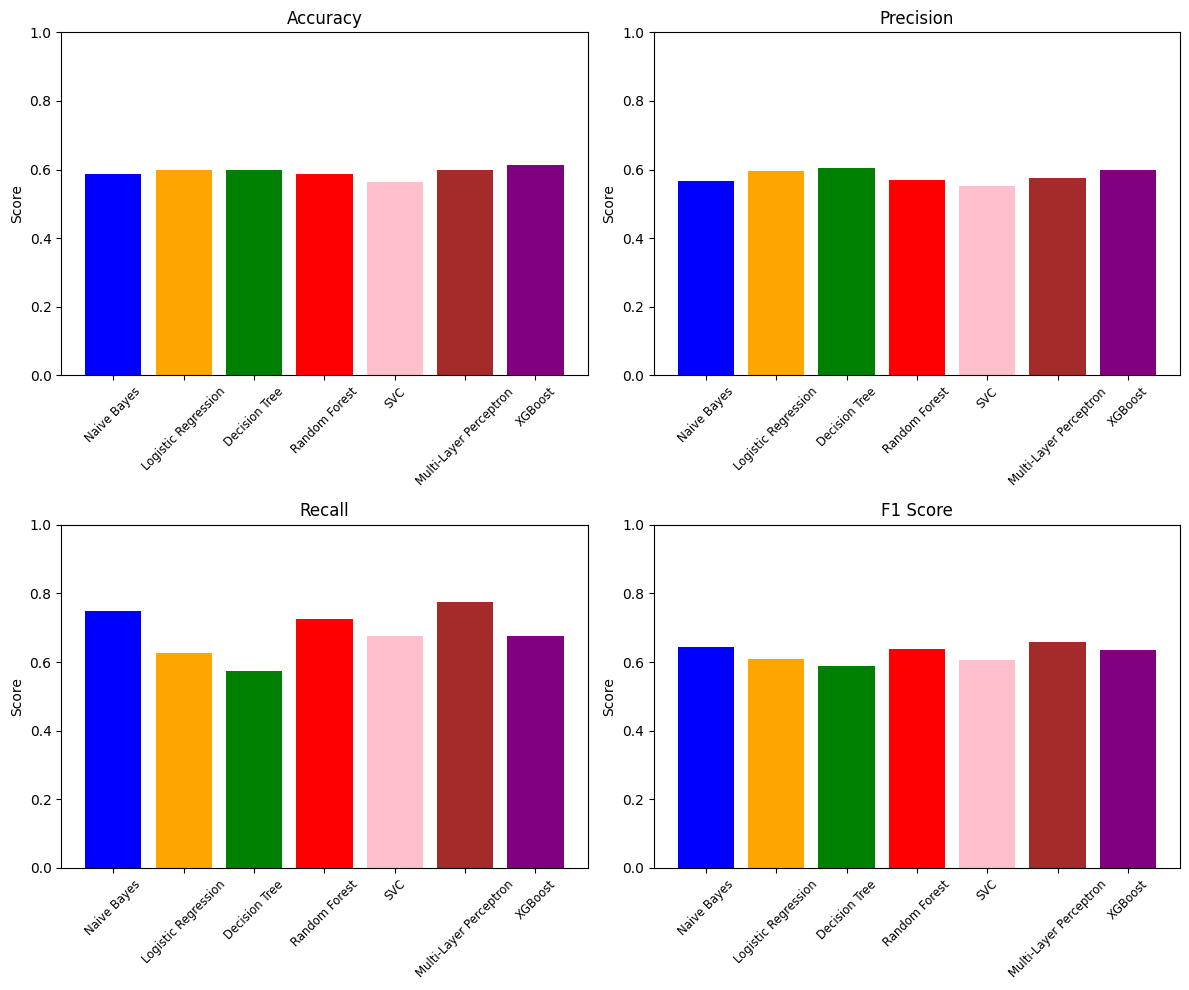

Classifier: Naive Bayes
Accuracy: 0.59
Precision: 0.57
Recall: 0.75
F1 Score: 0.65
------------------------------
Classifier: Logistic Regression
Accuracy: 0.60
Precision: 0.60
Recall: 0.62
F1 Score: 0.61
------------------------------
Classifier: Decision Tree
Accuracy: 0.60
Precision: 0.61
Recall: 0.57
F1 Score: 0.59
------------------------------
Classifier: Random Forest
Accuracy: 0.59
Precision: 0.57
Recall: 0.72
F1 Score: 0.64
------------------------------
Classifier: SVC
Accuracy: 0.56
Precision: 0.55
Recall: 0.68
F1 Score: 0.61
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.60
Precision: 0.57
Recall: 0.78
F1 Score: 0.66
------------------------------
Classifier: XGBoost
Accuracy: 0.61
Precision: 0.60
Recall: 0.68
F1 Score: 0.64
------------------------------


In [19]:
import matplotlib.pyplot as plt

metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

___

# Using Lexicons

We will use different general purpose lexicons, and leverage them to perform unsupervised sentiment analysis, and compare the results. Also, we will use a domain-specific [lexicon](https://sraf.nd.edu/loughranmcdonald-master-dictionary/).

The best performing one, will be used to create an extra feature to add to our data, and verify if it improves the traiend classifier models accuracy.

## VADER Sentiment

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [21]:
vader_pred = []
for article in dataset["processed_synopsis"]:
    vader_pred.append(1 if analyzer.polarity_scores(article)['compound'] > 0 else 0)

In [22]:
print("Accuracy: ", accuracy_score(y, vader_pred))
print("Precision: ", precision_score(y, vader_pred))
print("Recall: ", recall_score(y, vader_pred))
print("F1: ", f1_score(y, vader_pred))

Accuracy:  0.5275
Precision:  0.5594713656387665
Recall:  0.5879629629629629
F1:  0.5733634311512416


## Afinn Sentiment

In [23]:
from afinn import Afinn

afn = Afinn()

In [24]:
scores = [afn.score(article) for article in dataset["processed_synopsis"]]
sentiment = [
    "positive" if score >= 0 else "negative"
    for score in scores
]

afinn_pred = []
for article in dataset["processed_synopsis"]:
    afinn_pred.append(1 if afn.score(article) > 0 else 0)

In [25]:
print("Accuracy: ", accuracy_score(y, afinn_pred))
print("Precision: ", precision_score(y, afinn_pred))
print("Recall: ", recall_score(y, afinn_pred))
print("F1: ", f1_score(y, afinn_pred))

Accuracy:  0.53
Precision:  0.5614035087719298
Recall:  0.5925925925925926
F1:  0.5765765765765766


## SentiWordNet

In [26]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

# nltk.download("sentiwordnet")
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")

sentiwordnet_pred = []
for article in dataset["processed_synopsis"]:
    tokenSentence = nltk.word_tokenize(article)
    posTagSentence = nltk.pos_tag(tokenSentence)

    sentimentPositive = 0.0
    sentimentNegative = 0.0
    articleCount = 0
    final_sentiment = 0

    for wordTagPair in posTagSentence:

        word = wordTagPair[0]
        posTag = wordTagPair[1]

        if posTag.startswith("J"):
            posTag = wn.ADJ
        elif posTag.startswith("R"):
            posTag = wn.ADV
        elif posTag.startswith("N"):
            posTag = wn.NOUN
        else:
            continue

        wordSynst = wn.synsets(word, pos=posTag)
        if not wordSynst:
            continue
        chosenSynst = wordSynst[0]
        sentiWordNet = swn.senti_synset(chosenSynst.name())
        sentimentPositive += sentiWordNet.pos_score()
        sentimentNegative += sentiWordNet.neg_score()
        articleCount += 1

    if sentimentPositive > sentimentNegative:
        final_sentiment = 1
    else:
        final_sentiment = 0

    sentiwordnet_pred.append(final_sentiment)

In [27]:
print("Accuracy: ", accuracy_score(y, sentiwordnet_pred))
print("Precision: ", precision_score(y, sentiwordnet_pred))
print("Recall: ", recall_score(y, sentiwordnet_pred))
print("F1: ", f1_score(y, sentiwordnet_pred))

Accuracy:  0.4875
Precision:  0.5369127516778524
Recall:  0.37037037037037035
F1:  0.4383561643835616


## Loughran McDonald Master Dictionary

A domain-specific lexicon, altered to better fit the problem at hand (converted to a binary classification problem. Explained in [prepare_lexicon](data/prepare_lexicon.ipynb) notebook).

In [28]:
loughran_mcdonald = pd.read_csv("data/loughran-mcdonald-lexicon.csv")
loughran_mcdonald.head()

,Word,Sentiment
0,abandon,0
1,abandoned,0
2,abandoning,0
3,abandonment,0
4,abandonments,0


In [29]:
def calculate_sentiment_score(article, lexicon):
    words = article.lower().split()
    positive_score = 0
    negative_score = 0
    for word in words:
        if word in lexicon["Word"].values:
            sentiment = lexicon.loc[lexicon["Word"] == word, "Sentiment"].values[0]
            if sentiment == 1:
                positive_score += 1
            elif sentiment == 0:
                negative_score += 1
    if positive_score > negative_score:
        return 1 
    else:
        return 0  

In [30]:
loughran_mcdonald_preds = dataset["processed_synopsis"].apply(
    lambda x: calculate_sentiment_score(x, loughran_mcdonald)
)

In [31]:
print("Accuracy: ", accuracy_score(y, loughran_mcdonald_preds))
print("Precision: ", precision_score(y, loughran_mcdonald_preds))
print("Recall: ", recall_score(y, loughran_mcdonald_preds))
print("F1: ", f1_score(y, loughran_mcdonald_preds))

Accuracy:  0.49
Precision:  0.75
Recall:  0.08333333333333333
F1:  0.15


Even tought this lexicon was domain specific, it probably wasn't comprehensive enough, or it didn't contain the key terms deemed necessary to accuratly predict sentiment.

___

As we can see, **Afinn** was the best in classifying sentiment, lets use it to add a feature to the dataset, and re-apply our classifier

In [32]:
dataset["afinn_pred"] = afinn_pred

In [33]:
afinn_preds = np.array(dataset["afinn_pred"]).reshape(-1, 1)

In [34]:
X2 = X.copy()
X2 = np.hstack((X2, afinn_preds))

In [35]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.2, random_state=42
)

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

print("\nLabel distribution in the training set:")
print(y_train2.value_counts())

print("\nLabel distribution in the test set:")
print(y_test2.value_counts())

(320, 7838) (320,)
(80, 7838) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


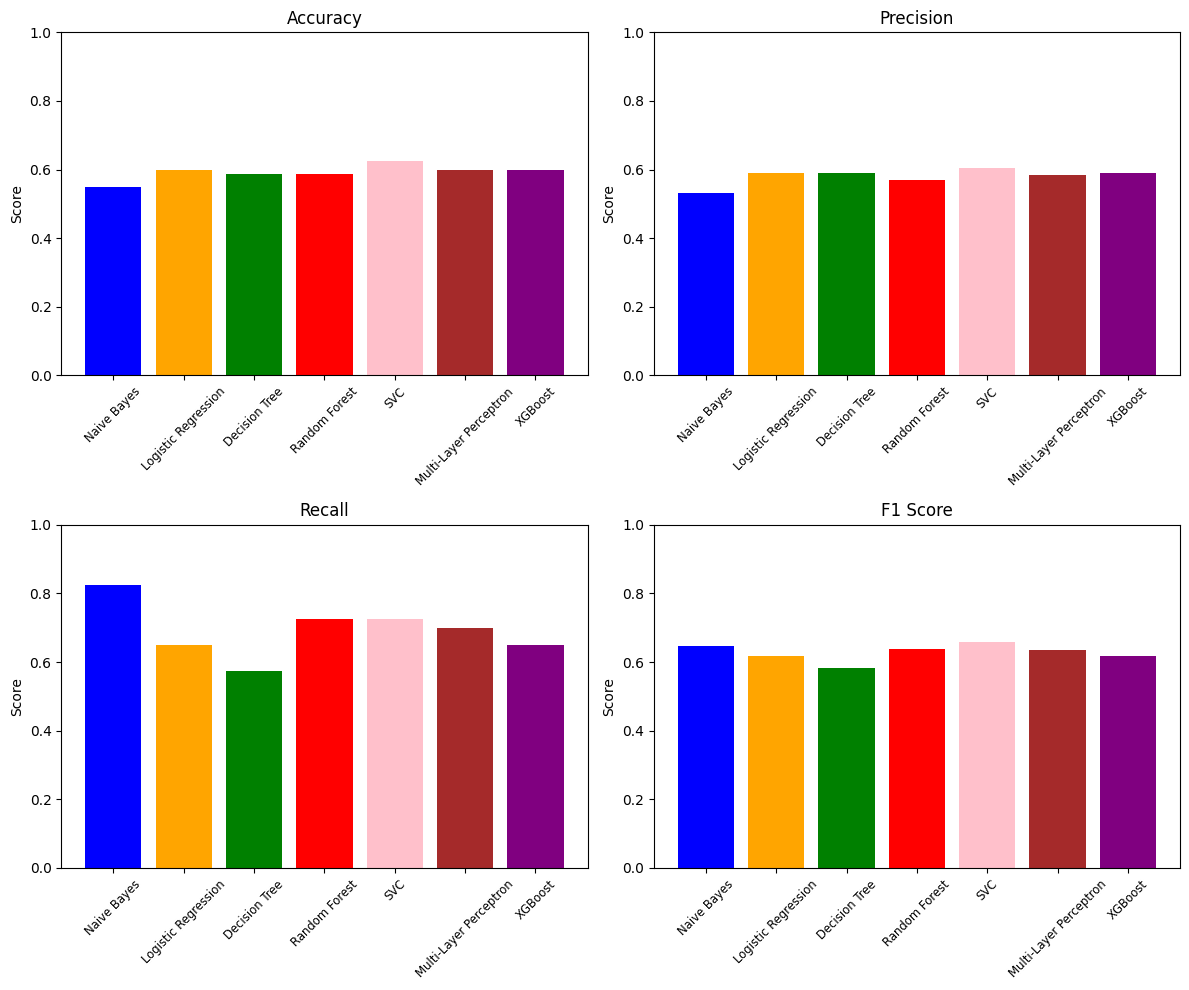

Classifier: Naive Bayes
Accuracy: 0.55
Precision: 0.53
Recall: 0.82
F1 Score: 0.65
------------------------------
Classifier: Logistic Regression
Accuracy: 0.60
Precision: 0.59
Recall: 0.65
F1 Score: 0.62
------------------------------
Classifier: Decision Tree
Accuracy: 0.59
Precision: 0.59
Recall: 0.57
F1 Score: 0.58
------------------------------
Classifier: Random Forest
Accuracy: 0.59
Precision: 0.57
Recall: 0.72
F1 Score: 0.64
------------------------------
Classifier: SVC
Accuracy: 0.62
Precision: 0.60
Recall: 0.72
F1 Score: 0.66
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.60
Precision: 0.58
Recall: 0.70
F1 Score: 0.64
------------------------------
Classifier: XGBoost
Accuracy: 0.60
Precision: 0.59
Recall: 0.65
F1 Score: 0.62
------------------------------


In [36]:
evaluations2 = {
    classifier_name: evaluate_classifier(classifier, X_train2, y_train2, X_test2, y_test2)
    for classifier_name, classifier in classifiers_tuned.items()
}
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations2.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations2.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

___

## Final Evaluation

In [37]:
max_name_length = max(len(name) for name in evaluations.keys() | evaluations2.keys())

print(
    f"{'Classifier Accuracy':<{max_name_length}} {'Base':<25} {'+Lexicon Features':<25}"
)
print("-" * (max_name_length + 60))  

for classifier_name in sorted(set(evaluations.keys()) | set(evaluations2.keys())):
    accuracy_evaluations = evaluations.get(classifier_name, (0,))[0]
    accuracy_evaluations2 = evaluations2.get(classifier_name, (0,))[0]
    print(
        f"{classifier_name:<{max_name_length}} {accuracy_evaluations:.2f} {' ' * 10} {accuracy_evaluations2:.2f}"
    )

Classifier Accuracy    Base                      +Lexicon Features        
----------------------------------------------------------------------------------
Decision Tree          0.60            0.59
Logistic Regression    0.60            0.60
Multi-Layer Perceptron 0.60            0.60
Naive Bayes            0.59            0.55
Random Forest          0.59            0.59
SVC                    0.56            0.62
XGBoost                0.61            0.60


As we can see, the best classifier model was:

XGBoost, with an accuracy of 61% on base and SVC with Lexicon predictions as a feature!